In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from typing import List
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold
from torch import nn,optim,tensor
from torch.utils import data
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,roc_curve

In [2]:
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = map(float, coord1.strip("()").split(","))
    lat2, lon2 = map(float, coord2.strip("()").split(","))
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [3]:
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
df = df.dropna()
df = pd.get_dummies(df,columns=['Weather_Conditions','Traffic_Conditions','Vehicle_Type','Order_Priority'])
df['GDistance'] = df.apply(lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']),axis=1)

df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Fast' if x <= df['Delivery_Time'].quantile(0.5) else 'Delayed')
df['Delivery_Status'] = df['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})
rush_hours = ['Morning', 'Evening']
df['Is_Rush_Hour'] = df['Order_Time'].isin(rush_hours).astype(bool)

scaler = pp.StandardScaler()
columnsToScale = ['Distance','GDistance','Delivery_Time','Order_Cost','Delivery_Person_Experience']
df[columnsToScale] = scaler.fit_transform(df[columnsToScale])
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,...,Traffic_Conditions_Medium,Vehicle_Type_Bicycle,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_High,Order_Priority_Low,Order_Priority_Medium,GDistance,Delivery_Status,Is_Rush_Hour
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",-1.454738,-0.456512,Afternoon,4.1,3.0,-1.487932,0.501852,...,True,False,False,True,False,False,True,0.641395,0,False
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",1.439192,1.004325,Night,4.5,4.2,-0.264987,-1.634294,...,True,False,False,True,False,True,False,1.632526,0,False
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",-0.666417,1.369535,Night,3.3,3.4,-0.741529,1.092646,...,True,False,True,False,True,False,False,-0.471227,0,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.335835,-1.186930,Evening,3.2,3.7,1.382411,-0.923323,...,False,False,True,False,False,False,True,-0.791930,1,True
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",-0.700119,0.273907,Night,3.5,2.8,-1.280915,-0.779755,...,False,False,True,False,False,True,False,0.756045,0,False


In [4]:
x = df[['GDistance','Weather_Conditions_Sunny','Weather_Conditions_Rainy','Weather_Conditions_Cloudy','Weather_Conditions_Snowy','Traffic_Conditions_High','Traffic_Conditions_Low','Traffic_Conditions_Medium','Order_Priority_High','Order_Priority_Low','Order_Priority_Medium','Is_Rush_Hour']]
y = df[['Delivery_Status']]

mat = x.corr().abs()
cg = sb.clustermap(mat, row_cluster=True, col_cluster=False)
plt.close(cg.fig)
cols = mat.columns[cg.dendrogram_row.reordered_ind].tolist()
grid = np.array(cols).reshape(3, 4)

images = []
for _, row in x.iterrows():
    img = np.zeros(grid.shape)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            img[i, j] = row[grid[i, j]]
    images.append(img)
images = np.array(images)[:, np.newaxis, :, :]

kf = KFold(n_splits=5,shuffle=True,random_state=42)
datas = data.TensorDataset(tensor(images), tensor(np.array(y),dtype=float))

In [5]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv = nn.Conv2d(1,8,kernel_size=3,stride=1,padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc = nn.Linear(8*1*2,2)

  def forward(self,x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

Fold 1:
Epoch 10 Loss: 3.259
Epoch 20 Loss: 3.054
Epoch 30 Loss: 2.857
Epoch 40 Loss: 2.713
Epoch 50 Loss: 2.539

Accuracy Score: 0.725
Precision Score: 0.7272727272727273
Recall Score: 0.7619047619047619
F1 Score: 0.7441860465116279
Confusion Matrix:
 [[13  6]
 [ 5 16]]


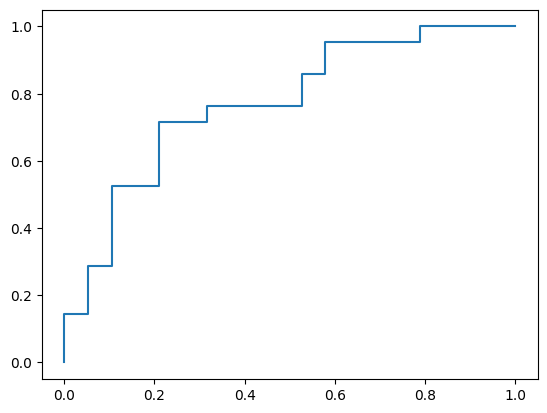

Fold 2:
Epoch 10 Loss: 3.197
Epoch 20 Loss: 3.002
Epoch 30 Loss: 2.805
Epoch 40 Loss: 2.643
Epoch 50 Loss: 2.528

Accuracy Score: 0.6
Precision Score: 0.5238095238095238
Recall Score: 0.6470588235294118
F1 Score: 0.5789473684210527
Confusion Matrix:
 [[13 10]
 [ 6 11]]


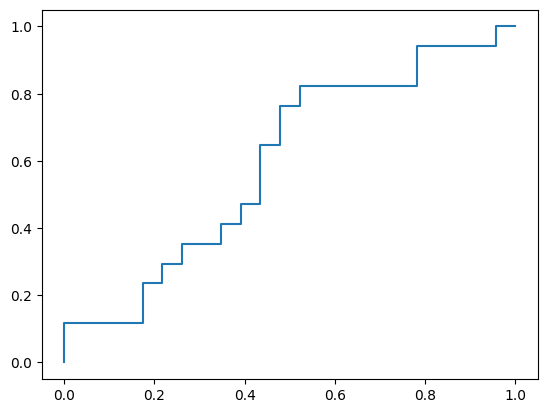

Fold 3:
Epoch 10 Loss: 3.184
Epoch 20 Loss: 2.991
Epoch 30 Loss: 2.848
Epoch 40 Loss: 2.700
Epoch 50 Loss: 2.618

Accuracy Score: 0.425
Precision Score: 0.5238095238095238
Recall Score: 0.4583333333333333
F1 Score: 0.4888888888888889
Confusion Matrix:
 [[ 6 10]
 [13 11]]


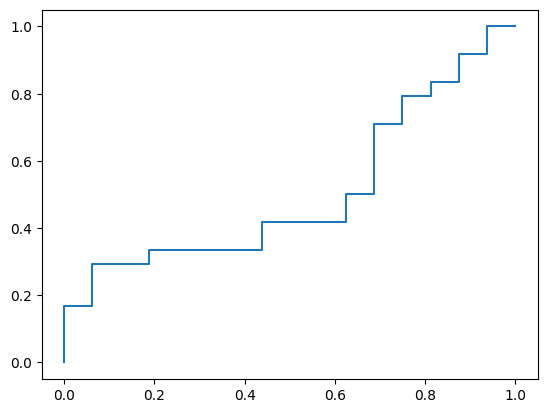

Fold 4:
Epoch 10 Loss: 3.211
Epoch 20 Loss: 2.906
Epoch 30 Loss: 2.644
Epoch 40 Loss: 2.437
Epoch 50 Loss: 2.266

Accuracy Score: 0.45
Precision Score: 0.4444444444444444
Recall Score: 0.4
F1 Score: 0.42105263157894735
Confusion Matrix:
 [[10 10]
 [12  8]]


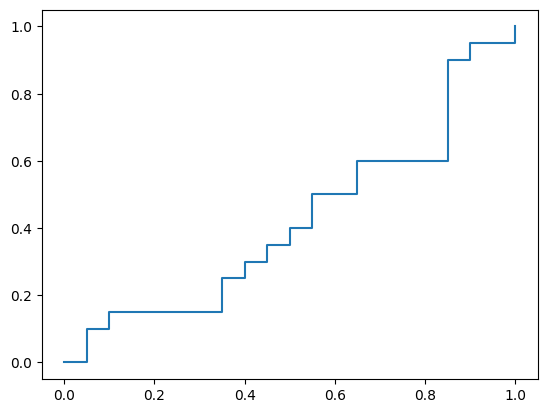

Fold 5:
Epoch 10 Loss: 3.270
Epoch 20 Loss: 2.965
Epoch 30 Loss: 2.796
Epoch 40 Loss: 2.672
Epoch 50 Loss: 2.603

Accuracy Score: 0.625
Precision Score: 0.5789473684210527
Recall Score: 0.6111111111111112
F1 Score: 0.5945945945945946
Confusion Matrix:
 [[14  8]
 [ 7 11]]


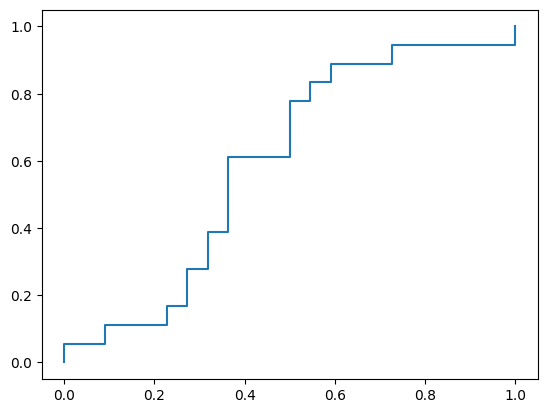

In [6]:
for f,(train_index, test_index) in enumerate(kf.split(datas)):
  print(f'Fold {f+1}:')
  cnn = CNN().to('cpu')
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn.parameters(),lr=0.01)
  train_subset = data.Subset(datas, train_index)
  test_subset = data.Subset(datas, test_index)

  train_loader = data.DataLoader(train_subset, batch_size=32, shuffle=True)
  test_loader = data.DataLoader(test_subset, batch_size=32, shuffle=False)

  for i in range(50):
    epoch_loss = 0.0
    for images,labels in train_loader:
      images = images.to('cpu').to(torch.float32)
      labels = labels.to('cpu')
      optimizer.zero_grad()
      outputs = cnn(images)
      loss = criterion(outputs,labels.squeeze().long())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().cpu().item()

    if((i+1)%10==0):
      print(f'Epoch {i+1} Loss: {epoch_loss:.3f}')
  print()

  cnn.eval()
  actual = []
  predicted = []
  predicted_prob = []

  for images,labels in test_loader:
    images = images.to('cpu').to(torch.float32)
    outputs = cnn(images)
    _,preds = torch.max(outputs.data,1)
    probs = torch.softmax(outputs, dim=1)
    predicted_prob.extend(probs[:,1].tolist())
    actual.extend(labels.tolist())
    predicted.extend(preds.tolist())

  print("Accuracy Score:",accuracy_score(actual,predicted))
  print("Precision Score:",precision_score(actual,predicted))
  print("Recall Score:",recall_score(actual,predicted))
  print("F1 Score:",f1_score(actual,predicted))
  print("Confusion Matrix:\n",confusion_matrix(actual,predicted))
  fpr, tpr, _ = roc_curve(actual, predicted_prob)
  plt.plot(fpr, tpr)
  plt.show()

In [7]:
class CNN2(nn.Module):
  def __init__(self):
    super(CNN2,self).__init__()
    self.conv1 = nn.Conv2d(1,8,kernel_size=3,stride=1,padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=1,stride=1)
    self.fc = nn.Linear(16*1*2,2)

  def forward(self,x):
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

Fold 1:
Epoch 10 Loss: 3.153
Epoch 20 Loss: 2.945
Epoch 30 Loss: 2.585
Epoch 40 Loss: 2.105
Epoch 50 Loss: 1.693

Accuracy Score: 0.65
Precision Score: 0.7333333333333333
Recall Score: 0.5238095238095238
F1 Score: 0.6111111111111112
Confusion Matrix:
 [[15  4]
 [10 11]]


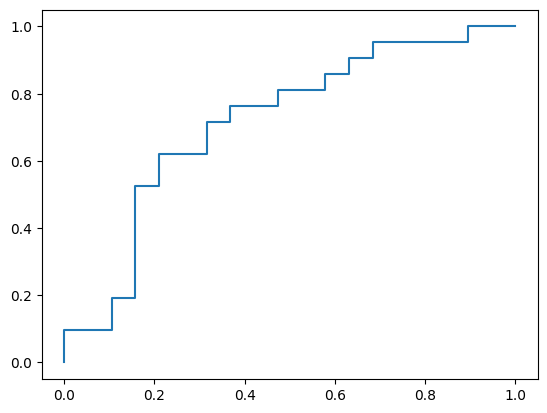

Fold 2:
Epoch 10 Loss: 3.158
Epoch 20 Loss: 2.736
Epoch 30 Loss: 2.267
Epoch 40 Loss: 2.048
Epoch 50 Loss: 1.825

Accuracy Score: 0.6
Precision Score: 0.5238095238095238
Recall Score: 0.6470588235294118
F1 Score: 0.5789473684210527
Confusion Matrix:
 [[13 10]
 [ 6 11]]


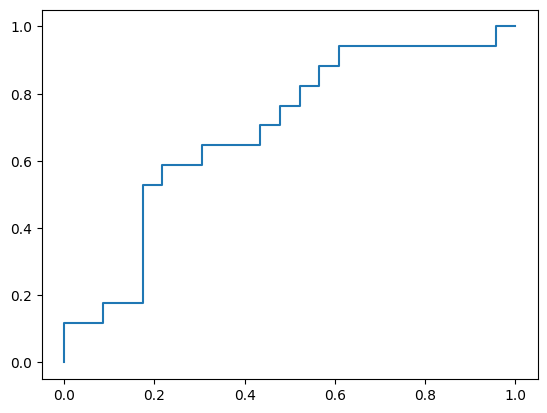

Fold 3:
Epoch 10 Loss: 2.978
Epoch 20 Loss: 2.339
Epoch 30 Loss: 1.802
Epoch 40 Loss: 1.631
Epoch 50 Loss: 1.186

Accuracy Score: 0.425
Precision Score: 0.5238095238095238
Recall Score: 0.4583333333333333
F1 Score: 0.4888888888888889
Confusion Matrix:
 [[ 6 10]
 [13 11]]


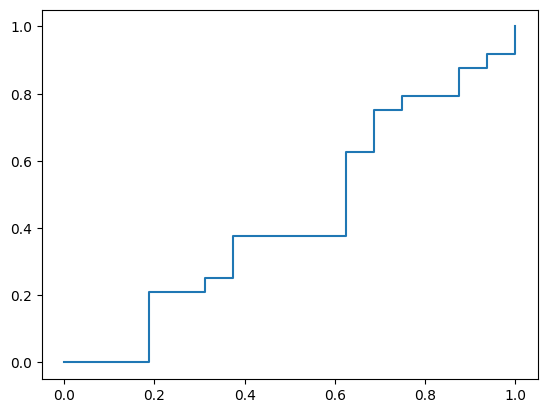

Fold 4:
Epoch 10 Loss: 3.131
Epoch 20 Loss: 2.564
Epoch 30 Loss: 2.150
Epoch 40 Loss: 1.838
Epoch 50 Loss: 1.651

Accuracy Score: 0.4
Precision Score: 0.3333333333333333
Recall Score: 0.2
F1 Score: 0.25
Confusion Matrix:
 [[12  8]
 [16  4]]


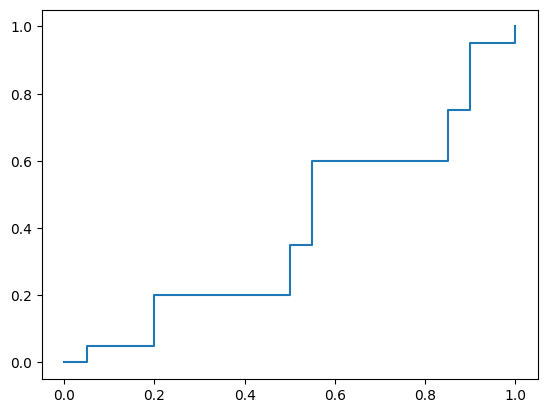

Fold 5:
Epoch 10 Loss: 3.222
Epoch 20 Loss: 2.649
Epoch 30 Loss: 2.105
Epoch 40 Loss: 1.773
Epoch 50 Loss: 1.552

Accuracy Score: 0.5
Precision Score: 0.4375
Recall Score: 0.3888888888888889
F1 Score: 0.4117647058823529
Confusion Matrix:
 [[13  9]
 [11  7]]


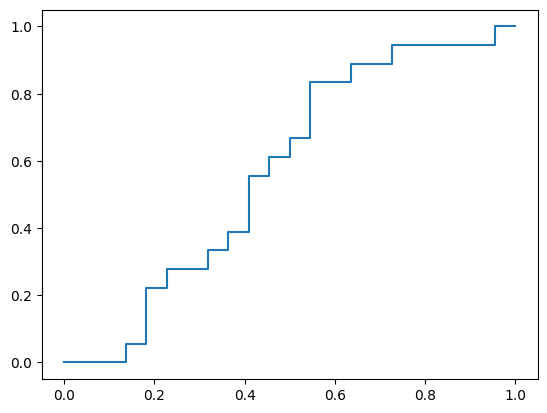

In [8]:
for f,(train_index, test_index) in enumerate(kf.split(datas)):
  print(f'Fold {f+1}:')
  cnn2 = CNN2().to('cpu')
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(cnn2.parameters(),lr=0.01)
  train_subset = data.Subset(datas, train_index)
  test_subset = data.Subset(datas, test_index)

  train_loader = data.DataLoader(train_subset, batch_size=32, shuffle=True)
  test_loader = data.DataLoader(test_subset, batch_size=32, shuffle=False)

  for i in range(50):
    epoch_loss = 0.0
    for images,labels in train_loader:
      images = images.to('cpu').to(torch.float32)
      labels = labels.to('cpu')
      optimizer.zero_grad()
      outputs = cnn2(images)
      loss = criterion(outputs,labels.squeeze().long())
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().cpu().item()

    if((i+1)%10==0):
      print(f'Epoch {i+1} Loss: {epoch_loss:.3f}')
  print()

  cnn2.eval()
  actual = []
  predicted = []
  predicted_prob = []

  for images,labels in test_loader:
    images = images.to('cpu').to(torch.float32)
    outputs = cnn2(images)
    _,preds = torch.max(outputs.data,1)
    probs = torch.softmax(outputs, dim=1)
    predicted_prob.extend(probs[:,1].tolist())
    actual.extend(labels.tolist())
    predicted.extend(preds.tolist())

  print("Accuracy Score:",accuracy_score(actual,predicted))
  print("Precision Score:",precision_score(actual,predicted))
  print("Recall Score:",recall_score(actual,predicted))
  print("F1 Score:",f1_score(actual,predicted))
  print("Confusion Matrix:\n",confusion_matrix(actual,predicted))
  fpr, tpr, _ = roc_curve(actual, predicted_prob)

  plt.plot(fpr, tpr)
  plt.show()

In this assignment, a model is used for predicting delivery status using Traffic, Weather, Geographic Distance, Delivery time etc. As CNN feeds on a image, these raw values are converted into a 2D image. This image has a speciality, the nearby values used to create this image will have higher correlation. In that way CNN can learn more from that window. For evaluating K-Fold method is used, as it helps reduce overfitting and unseen datas can be trained for this model. Scores achieved in one of the run on each Fold are;

# Simple CNN
## Fold 1
1. Accuracy Score:  0.575
2. Precision Score:  0.6428571428571429
3. Recall Score:  0.42857142857142855
4. F1 Score:  0.5142857142857142

## Fold 2
1. Accuracy Score:  0.6
2. Precision Score:  0.5238095238095238
3. Recall Score:  0.6470588235294118
4. F1 Score:  0.5789473684210527

## Fold 3
1. Accuracy Score:  0.45
2. Precision Score:  0.5416666666666666
3. Recall Score:  0.5416666666666666
4. F1 Score:  0.5416666666666666

## Fold 4
1. Accuracy Score:  0.4
2. Precision Score:  0.3888888888888889
3. Recall Score:  0.35
4. F1 Score:  0.3684210526315789

## Fold 5
1. Accuracy Score:  0.525
2. Precision Score:  0.48
3. Recall Score:  0.6666666666666666
4. F1 Score:  0.5581395348837209

# 2 Layer CNN
## Fold 1
1. Accuracy Score: 0.6
2. Precision Score: 0.6923076923076923
3. Recall Score: 0.42857142857142855
4. F1 Score: 0.5294117647058824

## Fold 2
1. Accuracy Score: 0.6
2. Precision Score: 0.5263157894736842
3. Recall Score: 0.5882352941176471
4. F1 Score: 0.5555555555555556

## Fold 3
1. Accuracy Score: 0.5
2. Precision Score: 0.5909090909090909
3. Recall Score: 0.5416666666666666
4. F1 Score: 0.5652173913043478

## Fold 4
1. Accuracy Score: 0.475
2. Precision Score: 0.47368421052631576
3. Recall Score: 0.45
4. F1 Score: 0.46153846153846156

## Fold 5
1. Accuracy Score: 0.525
2. Precision Score: 0.4782608695652174
3. Recall Score: 0.6111111111111112
4. F1 Score: 0.5365853658536586

On each fold the scores are almost similar, and as expected 2 Layer CNN has better scores than Single Layer CNN. Exceptions can be found. And also both models have better scores than the logistic model.